In [1]:
import nbpresent
nbpresent.__version__

'3.0.2'

In [4]:
#pre-req
#Install: Anaconda 4.4.0, Keras 2.0.6, Tensorflow 1.2.1, Python 3.6.1, RISE, NB-CONDA

<h1>Deep Learning Workshop - JULY 2017</h1>
<br>
<a href="http://home.cse.shirazu.ac.ir/~m.valipour/">Mojtaba Valipour</a> @ Shiraz University

<h5>Session 11 and 12 (Code Session) </h5>
<p><strong><span class="a"></span></strong> <span class="b"></span> <span></span></p>

<div style="width: 200px; float:right;margin:0 10px 10px 0" markdown="1">
![tfImage](elements/images/kerasLogo.png)
</div>

<img src="elements/images/phd-2.jpg" alt="Drawing" align="middle" style="width: 950px;"/>

Download Contents of Workshop Here:
https://github.com/mvpcom/ShirazuDL

# Variational AutoEncoder

* probabilistic  approach 
* Constraints on the encoded representations

* Learns a Latent Variable Model of the data
* Unobserved variable that represent a probabilistic model

* Generally no parameter tuning required 

## Latent Variable Model
    * Learns a set of latent vaiables 
    * roughly follow unit guassian
    * Decoder acts as a complex mapping function of the latent variable


any distibution in d dimensions can be generated by taking a set of d normally distributed variables, and mapping them through a complex function

* Performed in the network using a simple paramterization trick
* Instead of learning real values, we are learning means and standard deviation in the encoding 

Loss Function:
    * Optimization is performed using a modified loss function that combines two errors.
    
    * 1. Image Error
        Measures how closely the reconstructed image matches the original image
    * 2. KL Divergence
        How closely the latent variables match a unit guassian

Why VAE?
    * Allows unsupervised learning of complex distributions
    * Generative model so provides a framework for generation of new examples
    * Generally no parameter tuning required

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

In [22]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [23]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

In [26]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [27]:
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [28]:
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

* Binary Cross Entropy: $-\Sigma_x p(x) log q(x)$ 
* KL Divergence: $D_{KL}(P||Q) = \int_{\infty}^{\infty} p(x) log \frac{p(x)}{q(x)} dx$

In [31]:
# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

In [32]:
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

C:\Users\vpcom\Anaconda4\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  app.launch_new_instance()


In [33]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [34]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s - loss: 190.3889 - val_loss: 172.0429
Epoch 2/50
60000/60000 [==============================] - 17s - loss: 169.8644 - val_loss: 167.8005
Epoch 3/50
60000/60000 [==============================] - 17s - loss: 166.8064 - val_loss: 165.5044
Epoch 4/50
60000/60000 [==============================] - 20s - loss: 164.6181 - val_loss: 164.0783
Epoch 5/50
60000/60000 [==============================] - 20s - loss: 163.0895 - val_loss: 162.4174
Epoch 6/50
60000/60000 [==============================] - 19s - loss: 161.8796 - val_loss: 161.4449
Epoch 7/50
60000/60000 [==============================] - 19s - loss: 160.8072 - val_loss: 160.2862 16
Epoch 8/50
60000/60000 [==============================] - 21s - loss: 159.8820 - val_loss: 160.2154
Epoch 9/50
60000/60000 [==============================] - 20s - loss: 159.0669 - val_loss: 158.8752
Epoch 10/50
60000/60000 [======================

In [ ]:
# ignore training for now, just load the model
from keras.models import load_model
vae = load_model('vae.h5')

In [44]:
# save models and weights
vae.save('vae.h5')

In [35]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

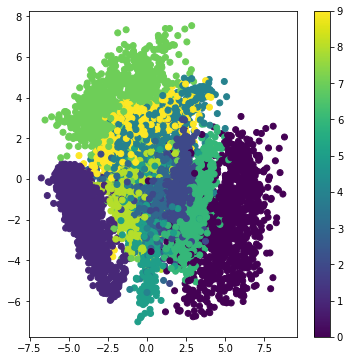

In [36]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

In [37]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [38]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

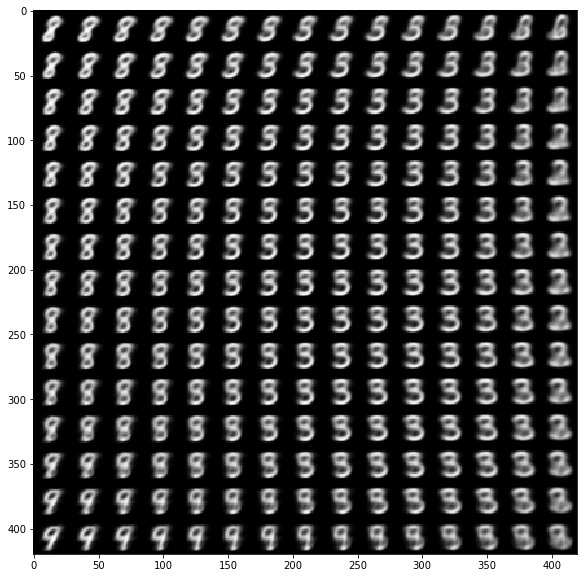

In [39]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
References: http://kvfrans.com/variational-autoencoders-explained/

# Recurrent Neural Network

What is RNN? 
<div style="width: 200px; float:right;margin:0 100px 10px 0" markdown="1">
![tfImage](elements/images/02R/RNN-rolled.png)
</div>

<div style="width: 1400px; float:right;margin:0 100px 10px 0" markdown="1">
![tfImage](elements/images/02R/RNN-unrolled.png)
</div>

<div style="width: 800px; float:right;margin:0 100px 10px 0" markdown="1">
![tfImage](elements/images/02R/LSTM3-chain.png)
</div>

Applications:
    * Speech Recognition 
    * Language Modeling
    * Translation
    * Image Captioning

## IMDB Sentiment Classification Task

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

In [3]:
# Convolution
kernel_size = 5
filters = 64
pool_size = 4

In [4]:
# LSTM
lstm_output_size = 70

In [5]:
# Training
batch_size = 30
epochs = 2

In [6]:
from keras.datasets import imdb
print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [7]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)


In [9]:
model = Sequential()

In [10]:
model.add(Embedding(max_features, embedding_size, input_length=maxlen))

In [11]:
model.add(Dropout(0.25))

In [12]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

In [13]:
model.add(MaxPooling1D(pool_size=pool_size))

In [14]:
model.add(LSTM(lstm_output_size))

In [15]:
model.add(Dense(1))

In [16]:
model.add(Activation('sigmoid'))

In [17]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
metrics=['accuracy'])

In [18]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 217s - loss: 0.3959 - acc: 0.8129 - val_loss: 0.3245 - val_acc: 0.8578
Epoch 2/2
25000/25000 [==============================] - 200s - loss: 0.2006 - acc: 0.9230 - val_loss: 0.3808 - val_acc: 0.8517


In [ ]:
# ignore training for now, just load the model
from keras.models import load_model
autoencoder = load_model('seqClassification.h5')

In [19]:
# save models and weights
model.save('seqClassification.h5')

In [20]:
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

24990/25000 [============================>.] - ETA: 0sTest score: 0.380799166593
Test accuracy: 0.851679993963


# Practice Time:

Train a model using Convolutional and Dense Only, what do you think, is LSTM work Better for IMDB Dataset?

# Generative Adversarial Networks

<div style="width: 600px; float:right;margin:0 100px 10px 0" markdown="1">
![tfImage](elements/images/02R/gan.png)
</div>

In [46]:
%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"

In [52]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

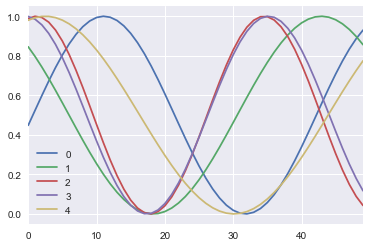

In [53]:
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

ax = pd.DataFrame(np.transpose(sample_data(5))).plot()

In [54]:
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               2200      
_________________________________________________________________
activation_4 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


In [55]:
def get_discriminative(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_3 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                115050    
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 102       
Total para

In [56]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_4 (Model)              (None, 50)                12250     
_________________________________________________________________
model_5 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [57]:
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)

pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 8s - loss: 0.0096     


In [58]:
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

In [65]:
def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    for epoch in e_range:
        if verbose:
            print(epoch, end='\r')
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

Epoch #50: Generative Loss: 1.1612205505371094, Discriminative Loss: 0.628898561000824
Epoch #100: Generative Loss: 3.085691213607788, Discriminative Loss: 0.0936538577079773
Epoch #150: Generative Loss: 4.2878642082214355, Discriminative Loss: 0.06413719058036804
Epoch #200: Generative Loss: 3.5389909744262695, Discriminative Loss: 0.07982337474822998
Epoch #250: Generative Loss: 3.474163293838501, Discriminative Loss: 0.0722859799861908
Epoch #300: Generative Loss: 4.0640482902526855, Discriminative Loss: 0.04861054569482803
Epoch #350: Generative Loss: 2.881814956665039, Discriminative Loss: 0.16075605154037476
Epoch #400: Generative Loss: 3.3083128929138184, Discriminative Loss: 0.0627705529332161
Epoch #450: Generative Loss: 4.019834995269775, Discriminative Loss: 0.03477225452661514
Epoch #500: Generative Loss: 4.604037284851074, Discriminative Loss: 0.019269676879048347


In [ ]:
# ignore training for now, just load the model
from keras.models import load_model
GAN = load_model('gan.h5')
G = load_model('G.h5')
D = load_model('D.h5')

In [67]:
GAN.save('gan.h5')
GAN.save('G.h5')
GAN.save('D.h5')

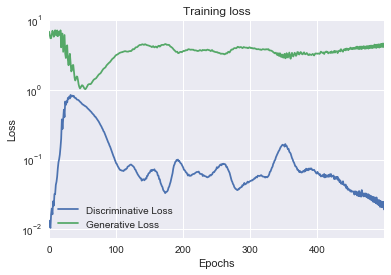

In [68]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

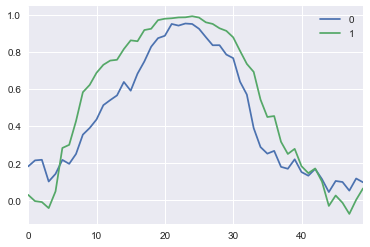

In [69]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

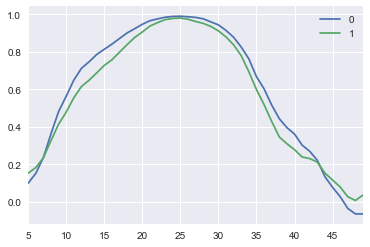

In [70]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()

References:
    1. https://blog.keras.io/building-autoencoders-in-keras.html
    2. http://www.birving.com/presentations/autoencoders/index.html
    3. http://www.deeplearningbook.org/contents/autoencoders.html
    4. https://github.com/fchollet/keras/blob/master/examples/imdb_cnn_lstm.py
    5. http://colah.github.io/posts/2015-08-Understanding-LSTMs/
    6. https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
    7. https://github.com/osh/KerasGAN
    8. http://www.rricard.me/machine/learning/generative/adversarial/networks/keras/tensorflow/2017/04/05/gans-part2.html